# Gradient Boosting Trees

## Notebook's Environment

In [1]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip install matplotlib==3.8.3
  %pip installnumpy==1.26.4
  %pip installpandas==2.2.1
  %pip installpandas_market_calendars==4.4.0
  %pip installpytz==2024.1
  %pip installscipy==1.12.0
  %pip installta==0.11.0
  %pip installyfinance==0.2.37

!python --version

Python 3.11.8


## Cloud Environment Setup

In [2]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

running localhost!


# Instruments

In [3]:
from constants import *

INTERVAL = YFinanceOptions.M15
TARGET_FUT, INTERVAL

('PA', '15m')

## Data Load

In [4]:
import pandas as pd
import numpy as np

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)
print(futs_df.columns)
futs_df.head(2)

./data/\futures_15m.csv
(4032, 144)
Index(['10Y_Open', '10Y_High', '10Y_Low', '10Y_Close', '10Y_Volume',
       '10Y_Spread', 'CL_Open', 'CL_High', 'CL_Low', 'CL_Close',
       ...
       'ZW_Low', 'ZW_Close', 'ZW_Volume', 'ZW_Spread', '^VIX_Open',
       '^VIX_High', '^VIX_Low', '^VIX_Close', '^VIX_Volume', '^VIX_Spread'],
      dtype='object', length=144)


,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Spread,CL_Open,CL_High,CL_Low,CL_Close,...,ZW_Low,ZW_Close,ZW_Volume,ZW_Spread,^VIX_Open,^VIX_High,^VIX_Low,^VIX_Close,^VIX_Volume,^VIX_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-24 22:16:00+00:00,4.213,4.213,4.205,4.205,8.0,0.008,80.849998,80.910004,80.589996,80.699997,...,555.75,556.25,494,4.25,13.67,13.67,13.65,13.65,0.0,0.02
2024-03-24 22:31:00+00:00,4.213,4.213,4.205,4.205,8.0,0.008,80.849998,80.910004,80.589996,80.699997,...,555.75,556.25,494,4.25,13.67,13.67,13.65,13.65,0.0,0.02


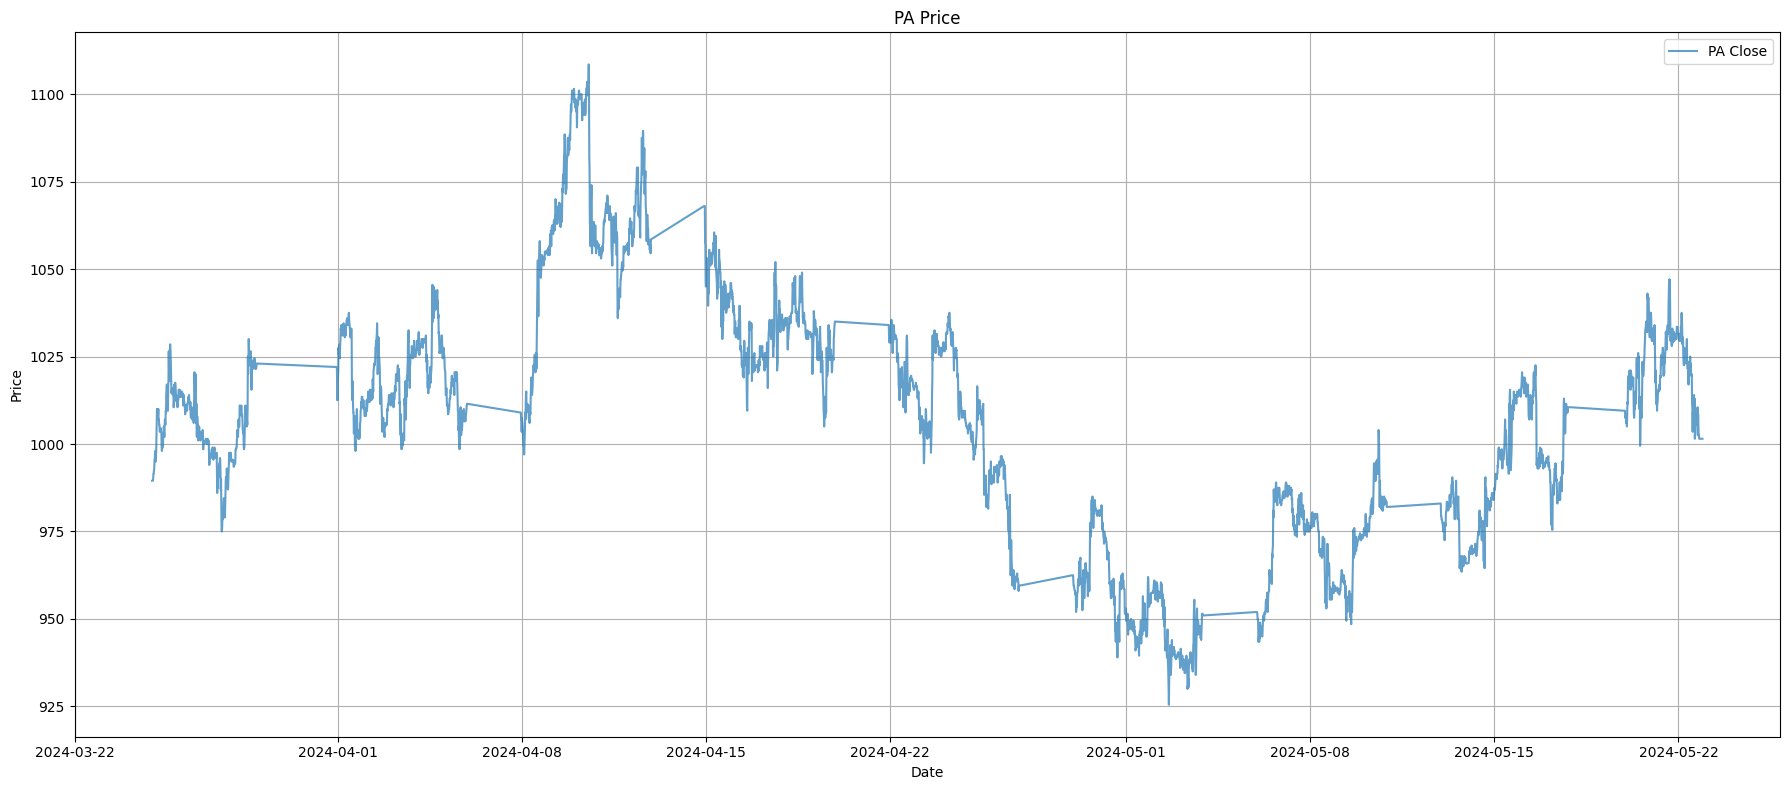

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))

plt.plot(futs_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', alpha=0.7)
plt.title(f'{TARGET_FUT} Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
target_fut_df = futs_df[[f"{TARGET_FUT}_Close", f"{TARGET_FUT}_High", f"{TARGET_FUT}_Low", f"{TARGET_FUT}_Open", f"{TARGET_FUT}_Volume"]]
target_fut_df.tail(5)

,PA_Close,PA_High,PA_Low,PA_Open,PA_Volume
Date,,,,,
2024-05-22 21:01:00+00:00,1001.5,1003.5,1000.5,1002.0,50
2024-05-22 21:16:00+00:00,1001.5,1003.5,1000.5,1002.0,50
2024-05-22 21:31:00+00:00,1001.5,1003.5,1000.5,1002.0,50
2024-05-22 21:46:00+00:00,1001.5,1003.5,1000.5,1002.0,50
2024-05-22 22:00:00+00:00,1001.5,1003.5,1000.5,1002.0,50


In [7]:
from quant_equations import get_ou, get_annualized_factor, calc_annualized_sharpe, deflated_sharpe_ratio, modulate_std

HALF_LIFE, HURST = get_ou(target_fut_df, f"{TARGET_FUT}_Close")

print("Half-Life:", HALF_LIFE)
print("Hurst:", HURST)

Half-Life: 199
Hurst: 0.48158477622658974
